# Import Needed Modules
---

In [1]:
import os
import torch
import numpy as np
from model import Model
from data_controller import EmbeddingDataset
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

/research2/lrbutler/miniconda3/envs/tisearch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Enable Cuda, Select Model for Image Embedding and Load in Dataset 
---

In [4]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load sentence embedding model
text_model = SentenceTransformer('all-MiniLM-L6-v2')

# Set paths
base_path = "/home/bchen1/data/"
image_embedding_dir = os.path.join(base_path, "formatted_data/test/image_embeddings")
image_file_dir = os.path.join(base_path, "dataset/train_images")
text_embedding_dir = os.path.join(base_path, "formatted_data/test/text_embeddings")
model_weights_path = "save_model2/best_model.pt"

# Load dataset and model
dataset = EmbeddingDataset(image_embedding_dir, text_embedding_dir)
input_shape, output_shape = dataset.get_feature_sizes()
layers = [512, 1024, 2048, 2048, 1024]
model = Model(input_size=384, output_size=768, layers=layers)
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.to(device)
model.eval()
print("Model loaded.")

Caching dataset into memory...
Model loaded.


# Load in Images
---

In [5]:
# Load image embeddings and filenames
image_files = sorted([f[:-4] for f in os.listdir(image_embedding_dir) if f.endswith(".npy")])
image_embeddings = [np.load(os.path.join(image_embedding_dir, f"{fname}.npy")) for fname in image_files]
image_embeddings = np.array(image_embeddings)
print(f"Loaded {len(image_embeddings)} image embeddings.")

Loaded 14027 image embeddings.


# Define functions for Text Embedding
---

In [6]:
# Encode sentence
def encode_text_to_embedding(text):
    text_features = text_model.encode(text)
    text_tensor = torch.tensor(text_features).unsqueeze(0).float().to(device)
    with torch.no_grad():
        predicted_embedding = model(text_tensor)
    return predicted_embedding.cpu().numpy()

# Find and display top K similar images
def find_similar_images(sentence_embedding, top_k=10):
    similarities = cosine_similarity(sentence_embedding.reshape(1, -1), image_embeddings)[0]
    sorted_indices = np.argsort(similarities)[::-1][:top_k]

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    for i, idx in enumerate(sorted_indices):
        img_id = image_files[idx]
        img_path = os.path.join(image_file_dir, f"{img_id}.jpg")
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Rank {i+1}\nSim: {similarities[idx]:.2f}")
    plt.tight_layout()
    plt.show()

# Prompts that work:
---
- Billboards
- women standing together
- taxi cabs
- beer
- wine
- grocery store
- clock
- A man giving a presentation
- Sports
- A soccer game
- A basketball game
- Runners

# Prompts that are kinda functional:
---
- A black and white image
- food
- A coffee machine, a blender
- Food on a plate

# Prompts that dont work:
---
- Something that is the color yellow
- a cigar
- hard alcohol
- A Wind turbine
- People dancing at a party
- An interview
- a cigarette
- An american football game
- A boxing match
- Swimmers

# Notes:
---
- Cannot tell the difference between a cross country runner and a track runner

# Below is an example input for finding images based upon text input

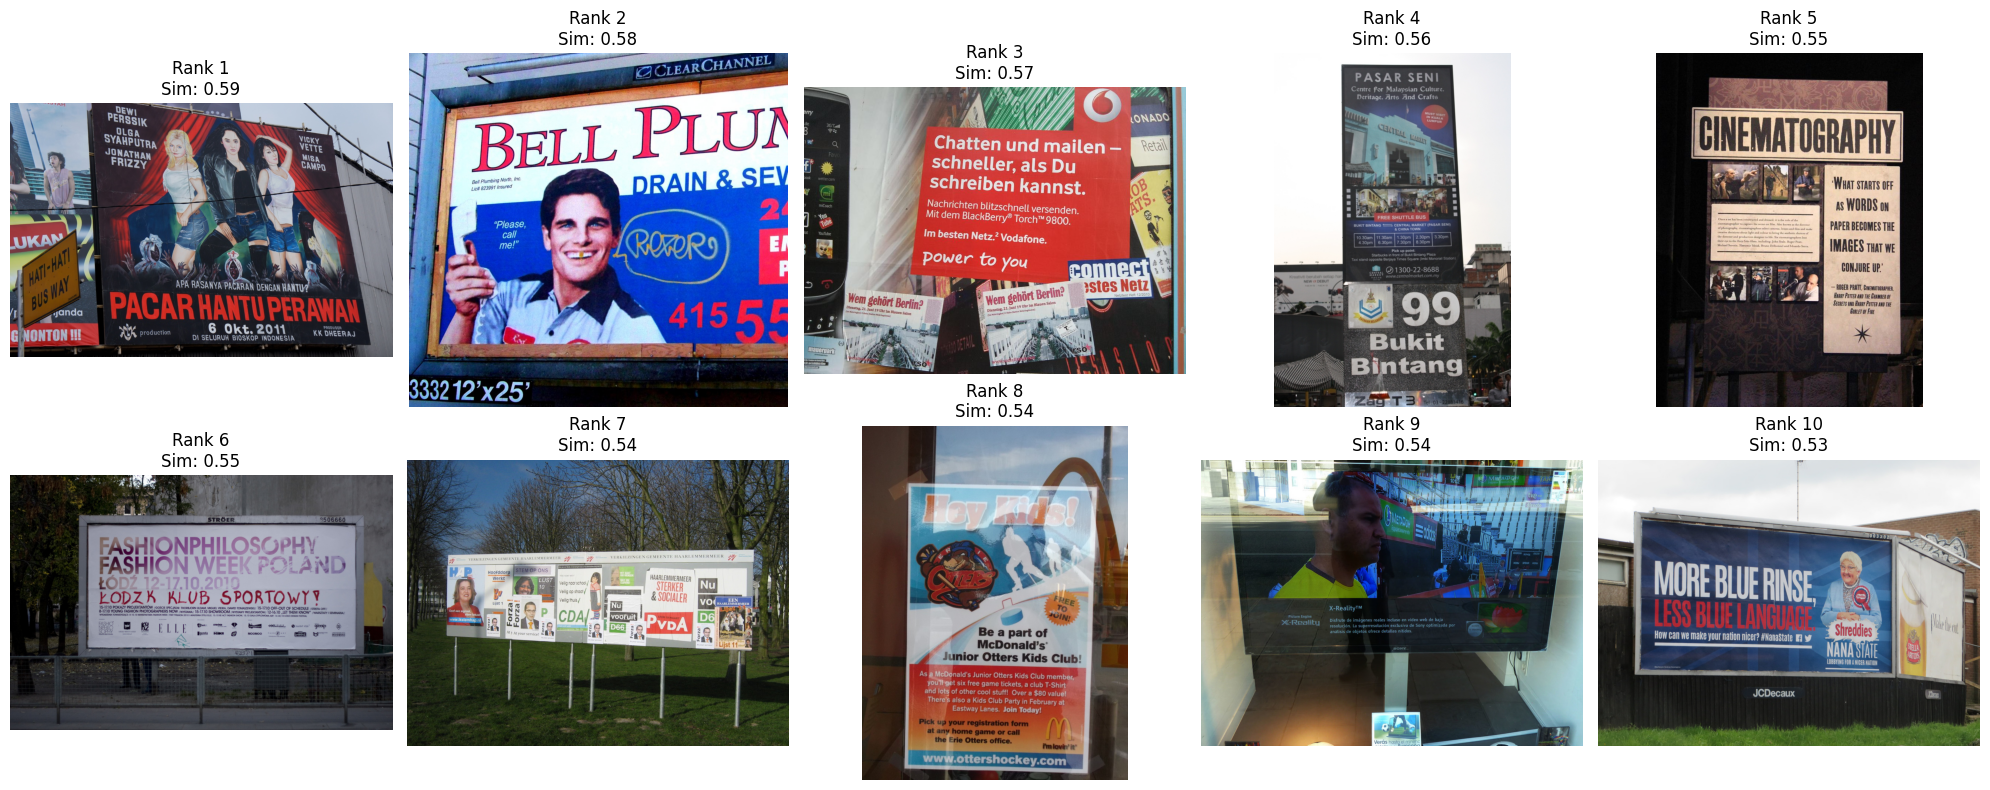

In [ ]:
query = ""
embedding = encode_text_to_embedding(query)
find_similar_images(embedding)

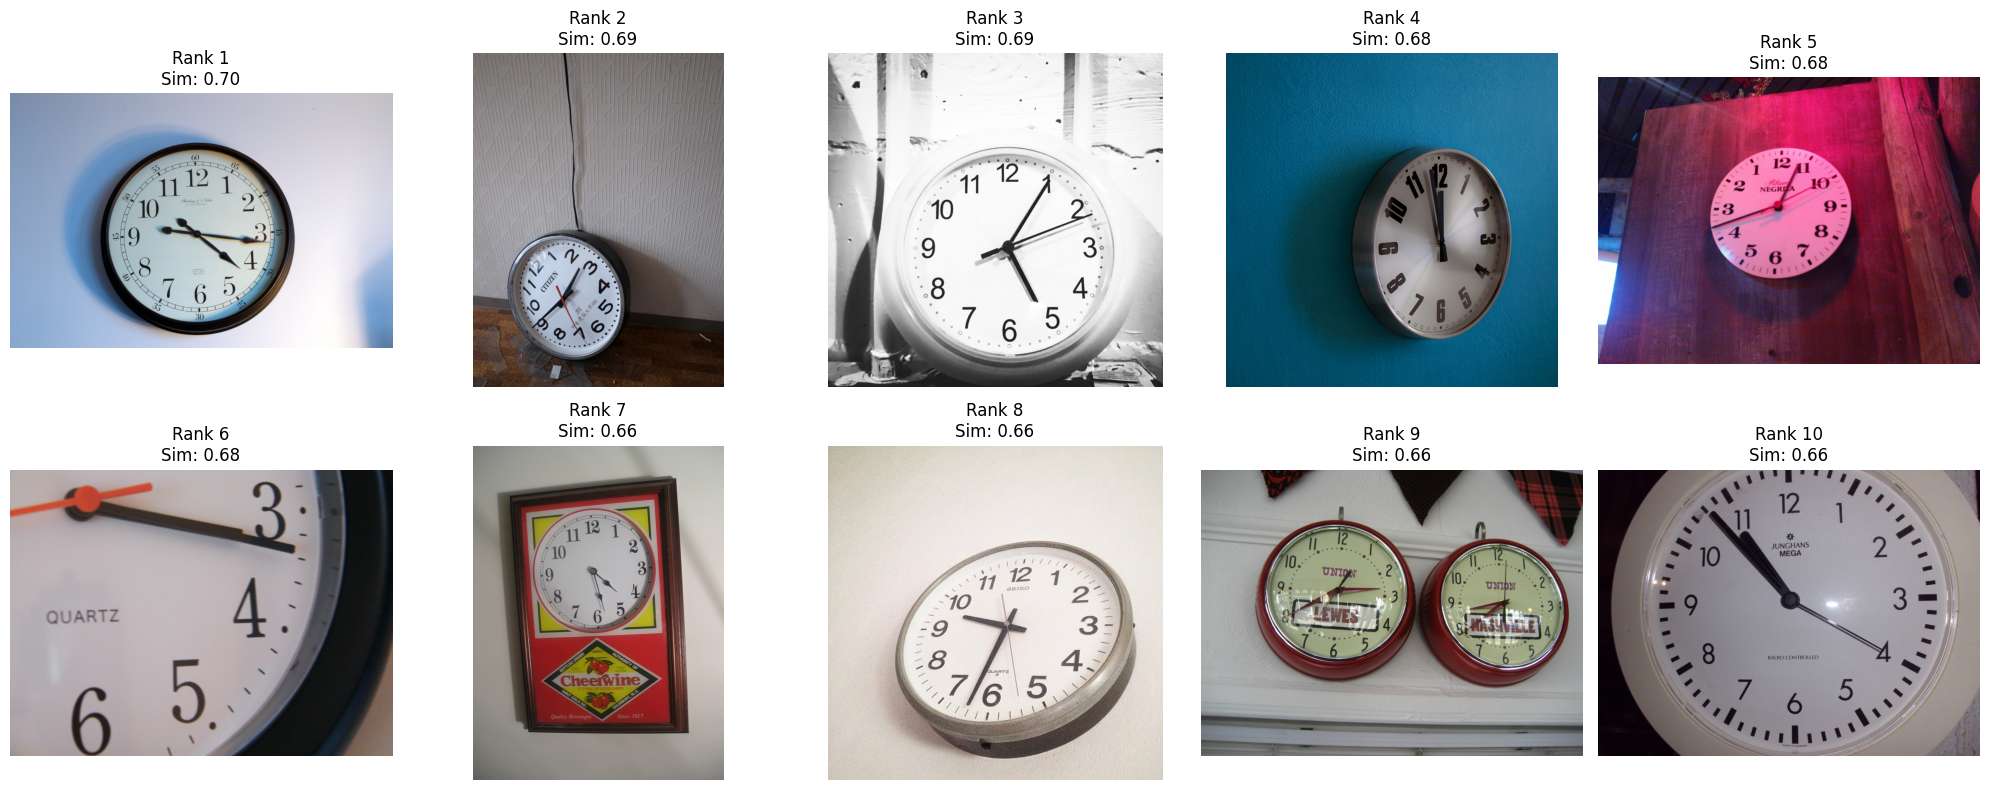

In [8]:
query = "A clock in a grocery store"
embedding = encode_text_to_embedding(query)
find_similar_images(embedding)